**Calculate the Customer Life Time Value (CLTV)**

# RFM METHOD

In [90]:
import numpy as np
import pandas as pd
import time
import datetime as dt

In [91]:
df = pd.read_csv("/content/customer_purchases.csv")

In [92]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [93]:
df['date'] = pd.DatetimeIndex(df['InvoiceDate']).date

In [94]:
recency_df = df.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']

In [95]:
recent_date=recency_df.LastPurshaceDate.max()
print(recent_date)


2011-12-09


In [96]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (recent_date - x).days)
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


In [97]:
# ## Frequency

In [98]:
# Dropping duplicates
df1= df
df1.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

In [99]:
# Calculating the frequency of purchases
frequency_df = df1.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [100]:
 ## Monetary
df['TotalCost'] = df['Quantity'] * df['UnitPrice']
monetary_df = df.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,163.16
2,12348.0,331.36
3,12349.0,15.00
4,12350.0,25.20


In [101]:
 ## Creating RFM Table
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,LastPurshaceDate,Recency,Frequency
0,12346.0,2011-01-18,325,2
1,12347.0,2011-12-07,2,7
2,12348.0,2011-09-25,75,4
3,12349.0,2011-11-21,18,1
4,12350.0,2011-02-02,310,1


In [102]:

rfm_df = temp_df.merge(monetary_df,on='CustomerID')

In [103]:
# Using CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
rfm_df.head()

,LastPurshaceDate,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,2011-01-18,325,2,0.00
12347.0,2011-12-07,2,7,163.16
12348.0,2011-09-25,75,4,331.36
12349.0,2011-11-21,18,1,15.00
12350.0,2011-02-02,310,1,25.20


In [104]:
# Ranking the each metric R , F & M
rfm_df['R_rank'] = rfm_df['Recency'].rank( ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
rfm_df.head()
# normalizing each rank with Max rank
rfm_df['R_rank_norm']=(rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm']=(rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm']=(rfm_df['F_rank']/rfm_df['M_rank'].max())*100
rfm_df.head()

rfm_df['RFM_Score']=0.15*rfm_df['R_rank_norm']+0.28*rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df=rfm_df.round(0)
rfm_df.head()

,LastPurshaceDate,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
CustomerID,,,,,,,,,,,
12346.0,2011-01-18,325,2,0.0,169.0,1722.0,178.0,4.0,39.0,39.0,34.0
12347.0,2011-12-07,2,7,163.0,4171.0,3560.0,3579.0,96.0,81.0,81.0,84.0
12348.0,2011-09-25,75,4,331.0,1642.0,2809.0,3976.0,38.0,64.0,64.0,60.0
12349.0,2011-11-21,18,1,15.0,3178.0,657.0,1066.0,73.0,15.0,15.0,24.0
12350.0,2011-02-02,310,1,25.0,238.0,657.0,1670.0,5.0,15.0,15.0,14.0



# **Segmenting** customers based on RFM score
# 0 - 50 - Low valued customer
# 50 - 75 - Medium valued customer
# 76 - 100 - High valued customer

In [105]:

rfm_df["Customer_segment"]=np.where(rfm_df['RFM_Score'] > 75 ,"High Value Customer",(np.where(rfm_df['RFM_Score'] < 50 , "Low value Customer" ,"Medium Value Customer")))
rfm_df.head()

,LastPurshaceDate,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
CustomerID,,,,,,,,,,,,
12346.0,2011-01-18,325,2,0.0,169.0,1722.0,178.0,4.0,39.0,39.0,34.0,Low value Customer
12347.0,2011-12-07,2,7,163.0,4171.0,3560.0,3579.0,96.0,81.0,81.0,84.0,High Value Customer
12348.0,2011-09-25,75,4,331.0,1642.0,2809.0,3976.0,38.0,64.0,64.0,60.0,Medium Value Customer
12349.0,2011-11-21,18,1,15.0,3178.0,657.0,1066.0,73.0,15.0,15.0,24.0,Low value Customer
12350.0,2011-02-02,310,1,25.0,238.0,657.0,1670.0,5.0,15.0,15.0,14.0,Low value Customer


In [106]:
#PREDECTIVE MODELLING

# Q.2 Predective Modeling , Probabilistic Model

In [107]:
pip install lifetimes

In [108]:
import lifetimes
import matplotlib.pyplot as plt

In [109]:
import matplotlib.pyplot as plt
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = df[features]
data_clv['TotalSales'] = data_clv['Quantity'].multiply(data_clv['UnitPrice'])
data_clv['InvoiceDate'] = pd.to_datetime(data_clv['InvoiceDate'])
print(data_clv.shape)
data_clv.head()


(25900, 6)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
7,17850.0,536366,2010-12-01 08:28:00,6,1.85,11.10
9,13047.0,536367,2010-12-01 08:34:00,32,1.69,54.08
21,13047.0,536368,2010-12-01 08:34:00,6,4.25,25.50
25,13047.0,536369,2010-12-01 08:35:00,3,5.95,17.85


In [110]:
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'CustomerID','InvoiceDate','TotalSales')
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,22.993333
2,12348.0,3.0,283.0,358.0,97.253333
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


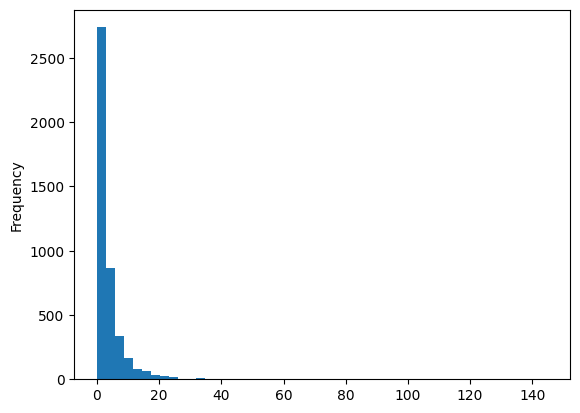

count    4372.000000
mean        3.413541
std         6.674343
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max       145.000000
Name: frequency, dtype: float64
---
Percentage of customers purchasing the item only once: 19.62%


In [111]:
summary['frequency'].plot(kind='hist', bins=50)
plt.show()

# Display summary statistics
print(summary['frequency'].describe())
print("---")

# Calculate percentage of one-time buyers
one_time_buyers = round((sum(summary['frequency'] == 1) / len(summary)) * 100, 2)
print(f"Percentage of customers purchasing the item only once: {one_time_buyers}%")

In [112]:
#Fitting the BG/NBD model
bgf = lifetimes. BetaGeoFitter (penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4372 subjects, a: 0.02, alpha: 55.62, b: 0.49, r: 0.84>

In [113]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.843025,0.026206,0.791661,0.894389
alpha,55.619383,2.088118,51.526671,59.712095
a,0.021519,0.006381,0.009012,0.034026
b,0.488673,0.176970,0.141812,0.835534


In [114]:

summary['probability_alive'] = bgf.conditional_probability_alive (summary['frequency'], summary['recency'], summary['T'])
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,0.0,0.0,325.0,0.000000,1.000000
1,12347.0,6.0,365.0,367.0,22.993333,0.995966
2,12348.0,3.0,283.0,358.0,97.253333,0.981687
3,12349.0,0.0,0.0,18.0,0.000000,1.000000
4,12350.0,0.0,0.0,310.0,0.000000,1.000000


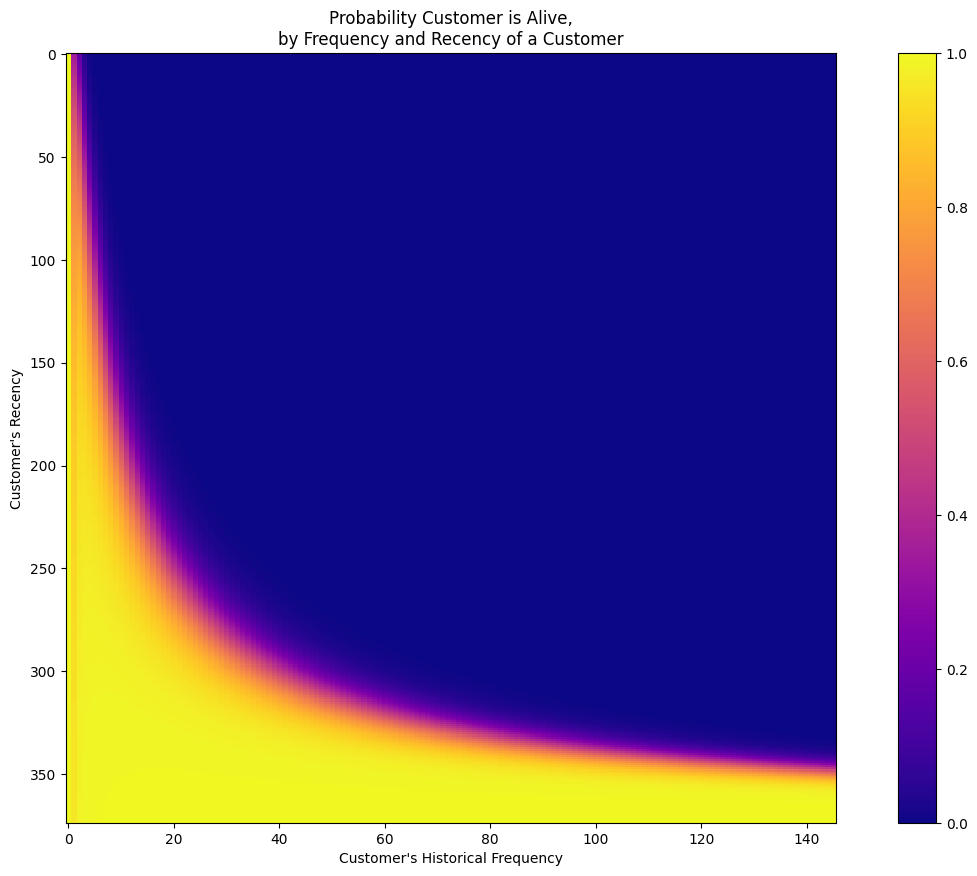

In [115]:

from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(16, 10))
plot_probability_alive_matrix(bgf, cmap='plasma')
plt.show()


In [116]:
t = 30
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']))
top_10_customers = summary.sort_values(by='pred_num_txn', ascending=False).head(10)
top_10_customers.reset_index(inplace=True)
top_10_customers

,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1895,14911.0,145.0,372.0,373.0,45.236483,0.999791,10.0
1,4042,17841.0,112.0,372.0,373.0,9.544821,0.999749,8.0
2,330,12748.0,114.0,373.0,373.0,5.457982,0.999810,8.0
3,2192,15311.0,90.0,373.0,373.0,43.113222,0.999760,6.0
4,568,13089.0,82.0,367.0,369.0,44.713902,0.999610,6.0
5,1674,14606.0,88.0,372.0,373.0,10.123523,0.999697,6.0
6,487,12971.0,71.0,369.0,372.0,51.797042,0.999494,5.0
7,3014,16422.0,66.0,352.0,369.0,61.474394,0.994981,5.0
8,803,13408.0,54.0,372.0,373.0,76.712407,0.999543,4.0
9,2099,15189.0,45.0,331.0,332.0,77.260000,0.999456,4.0


In [117]:
#checking the relationship between frequency and monetary_value
return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(2991, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347.0,6.0,365.0,367.0,22.993333,0.995966,0.0
2,12348.0,3.0,283.0,358.0,97.253333,0.981687,0.0
5,12352.0,6.0,260.0,296.0,-26.291667,0.991857,1.0
9,12356.0,2.0,303.0,325.0,25.950000,0.983167,0.0
11,12358.0,1.0,149.0,150.0,142.800000,0.957457,0.0


In [118]:
#checking the relationship between frequency and monetary_value
return_customers_summary[['frequency','monetary_value']].corr()


,frequency,monetary_value
frequency,1.000000,0.072713
monetary_value,0.072713,1.000000


In [119]:
return_customers_summary = return_customers_summary[return_customers_summary['monetary_value'] > 0]

In [120]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'], return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2681 subjects, p: 2.23, q: 1.06, v: 5.24>

In [121]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.232904,0.095091,2.046526,2.419282
q,1.061704,0.028088,1.006651,1.116757
v,5.237124,0.274339,4.699419,5.774829


In [122]:
summary = summary[summary['monetary_value']>0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],summary['monetary_value'])

In [123]:
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
1,12347.0,6.0,365.0,367.0,22.993333,0.995966,0.0,23.756772
2,12348.0,3.0,283.0,358.0,97.253333,0.981687,0.0,98.095452
9,12356.0,2.0,303.0,325.0,25.950000,0.983167,0.0,28.179210
11,12358.0,1.0,149.0,150.0,142.800000,0.957457,0.0,144.056274
12,12359.0,5.0,324.0,331.0,1.380000,0.994694,0.0,2.414083


In [124]:
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 40.26715887993627
Actual Average Sales: 38.419385969390525


In [125]:
summary["predicted_clv"] = ggf.customer_lifetime_value(bgf,
                                                      summary['frequency'],
                                                      summary['recency'],
                                                      summary['T'],
                                                      summary['monetary_value'],
                                                      time=1,
                                                      freq='D',
                                                      discount_rate=0.01)
summary.sort_values(by='pred_num_txn', ascending=False).head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
1895,14911.0,145.0,372.0,373.0,45.236483,0.999791,10.0,45.263974,457.038713
330,12748.0,114.0,373.0,373.0,5.457982,0.999810,8.0,5.502588,43.751615
4042,17841.0,112.0,372.0,373.0,9.544821,0.999749,8.0,9.589215,74.912351
1674,14606.0,88.0,372.0,373.0,10.123523,0.999697,6.0,10.179839,62.608965
568,13089.0,82.0,367.0,369.0,44.713902,0.999610,6.0,44.762685,259.104473


In [126]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
1,12347.0,6.0,365.0,367.0,22.993333,0.995966,0.0,23.756772,11.369512,0.0
2,12348.0,3.0,283.0,358.0,97.253333,0.981687,0.0,98.095452,26.548550,0.0
9,12356.0,2.0,303.0,325.0,25.950000,0.983167,0.0,28.179210,6.139053,0.0
11,12358.0,1.0,149.0,150.0,142.800000,0.957457,0.0,144.056274,36.620314,0.0
12,12359.0,5.0,324.0,331.0,1.380000,0.994694,0.0,2.414083,1.076859,0.0


In [127]:
profit_margin = 0.05
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347.0,6.0,365.0,367.0,22.993333,0.995966,0.0,23.756772,11.369512,0.0,0.568476
2,12348.0,3.0,283.0,358.0,97.253333,0.981687,0.0,98.095452,26.548550,0.0,1.327427
9,12356.0,2.0,303.0,325.0,25.950000,0.983167,0.0,28.179210,6.139053,0.0,0.306953
11,12358.0,1.0,149.0,150.0,142.800000,0.957457,0.0,144.056274,36.620314,0.0,1.831016
12,12359.0,5.0,324.0,331.0,1.380000,0.994694,0.0,2.414083,1.076859,0.0,0.053843


the CLV for each customer for the next 30 **days**

In [128]:
summary['CLV'].describe()

count    2681.000000
mean        1.263387
std         4.978443
min         0.005741
25%         0.182682
50%         0.376245
75%         0.854357
max       131.826949
Name: CLV, dtype: float64